# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

Project Instructions
The full dataset is 12GB, of which you can analyze a mini subset in the workspace on the following page. Optionally, you can choose to follow the instructions in the Extracurricular course to deploy a Spark cluster on the cloud using AWS or IBM Cloud to analyze a larger amount of data. Currently we have the full 12GB dataset available to you if you use AWS. If you use IBM, you can download a medium sized dataset to upload to your cluster.

Details on how to do this using AWS or IBM Cloud are included in the last lesson of the Extracurricular Spark Course content linked above. Note that this part is optional, and you will not receive credits to fund your deployment. You can do the IBM portion for free. Using AWS will cost you around $30 if you run a cluster up for a week with the settings we provide.

Once you've built your model, either in the classroom workspace or in the cloud with AWS or IBM, download your notebook and complete the remaining components of your Data Scientist Capstone project, including thorough documentation in a README file in your Github repository, as well as a web app or blog post explaining the technical details of your project. Be sure to review the Project Rubric thoroughly before submitting your project.

In [1]:
# import libraries
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import split
from pyspark.sql.window import Window
from pyspark.sql.functions import countDistinct as fcountDistinct
from pyspark.sql.functions import sum as fsum
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import count as fcount
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pyspark.sql.functions as f
import pandas as pd
import numpy as np
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from pyspark.sql.functions import when, col
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

In [2]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# dataset_path
stack_overflow_data = 'mini_sparkify_event_data.json'

## read the data 
df = spark.read.json(stack_overflow_data)

In [4]:
# Basic show
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [5]:
# check all columns
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
%%time
# show the 5 row data 
df.show(5, truncate = False)

+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|artist          |auth     |firstName|gender|itemInSession|lastName|length   |level|location                      |method|page    |registration |sessionId|song                         |status|ts           |userAgent                                                                                                      |userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|Martha Tilston  |Logg

In [7]:
# data dimensionality
print((df.count(), len(df.columns)))

(286500, 18)


In [8]:
from pyspark.sql.functions import col

# Check null values in each column
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    print(f"Column '{column}' has {null_count} null values.")


Column 'artist' has 58392 null values.
Column 'auth' has 0 null values.
Column 'firstName' has 8346 null values.
Column 'gender' has 8346 null values.
Column 'itemInSession' has 0 null values.
Column 'lastName' has 8346 null values.
Column 'length' has 58392 null values.
Column 'level' has 0 null values.
Column 'location' has 8346 null values.
Column 'method' has 0 null values.
Column 'page' has 0 null values.
Column 'registration' has 8346 null values.
Column 'sessionId' has 0 null values.
Column 'song' has 58392 null values.
Column 'status' has 0 null values.
Column 'ts' has 0 null values.
Column 'userAgent' has 8346 null values.
Column 'userId' has 0 null values.


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_unixtime, col

def data_wrangling(df):
    """
    Perform data cleaning operations on the input DataFrame.
    **Some step to cleans up**
    - Dropped the redundant Unnamed: 0 column.
    - Dropped rows where userId is missing.
    - Checked for duplicate rows;
    - Converted the ts and registration columns from epoch format to a human-readable date-time format.

    Args:
    - df (DataFrame): Input Spark DataFrame

    Returns:
    - DataFrame: Cleaned Spark DataFrame
    """

    # 1. Check for Duplicate Rows
    duplicate_count = df.count() - df.dropDuplicates().count()

    if duplicate_count > 0:
        print(f"Found {duplicate_count} duplicate rows.")
        df.select(df.columns).groupBy(df.columns).count().filter("count > 1").show(truncate=False)
    else:
        print("No duplicate rows found.")
    
    # 2. Drop Redundant Columns
    # 'Unnamed: 0' column might not exist in all datasets. So, handle potential errors.
    try:
        df = df.drop('Unnamed: 0')
    except:
        print("'Unnamed: 0' column not found. Skipping drop.")
    
    # 3. Handle Missing Values
    df = df.dropna(subset=['userId'])

    # 4. Check for Duplicate Rows and Remove
    df = df.dropDuplicates()

    # 5. Data Type Conversion
    df = df.withColumn("ts", from_unixtime(col("ts")/1000))
    df = df.withColumn("registration", from_unixtime(col("registration")/1000))
    
    # 6 handling null values in some columns
    # List of columns with null values
    columns_with_null = ["firstName", "gender", "lastName", "location", "registration", "userAgent"]

    # Drop rows with null values in specified columns
    for column in columns_with_null:
        df = df.filter(col(column).isNotNull())
    
    df = df.withColumn("length", when(col("length").isNull(), 0).otherwise(col("length")))
    
    return df


df = data_wrangling(df)


No duplicate rows found.


In [10]:
# data dimensionality
print((df.count(), len(df.columns)))

(278154, 18)


In [11]:
# after cleansing

# Check null values in each column
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    print(f"Column '{column}' has {null_count} null values.")

Column 'artist' has 50046 null values.
Column 'auth' has 0 null values.
Column 'firstName' has 0 null values.
Column 'gender' has 0 null values.
Column 'itemInSession' has 0 null values.
Column 'lastName' has 0 null values.
Column 'length' has 0 null values.
Column 'level' has 0 null values.
Column 'location' has 0 null values.
Column 'method' has 0 null values.
Column 'page' has 0 null values.
Column 'registration' has 0 null values.
Column 'sessionId' has 0 null values.
Column 'song' has 50046 null values.
Column 'status' has 0 null values.
Column 'ts' has 0 null values.
Column 'userAgent' has 0 null values.
Column 'userId' has 0 null values.


In [12]:
# from pyspark.sql.functions import avg

# # Ensure 'ts' is of type Long
# df = df.withColumn("ts", df["ts"].cast("long"))

# # Check the presence of Churn events
# churn_counts = df.groupBy("Churn").count().collect()

# # If both churned and non-churned users are present:
# if len(churn_counts) > 1:
    
#     # Calculate the session duration
#     session_end = df.groupBy("userId", "sessionId", "Churn") \
#                    .agg(((max("ts") - min("ts")) / (1000 * 60)).alias("session_duration_minutes"))

#     session_end.groupby("Churn").agg(avg("session_duration_minutes"), 
#                                      stddev("session_duration_minutes"), 
#                                      max("session_duration_minutes"), 
#                                      min("session_duration_minutes")).show()
# else:
#     print(f"There are only users with Churn = {churn_counts[0]['Churn']} in the dataset.")


In [13]:
# show ts and registration schema
df.select("ts", "registration").printSchema()

root
 |-- ts: string (nullable = true)
 |-- registration: string (nullable = true)



In [14]:
# head 20 for timestamp data
df.select("userId", "sessionId", "ts", "registration").show(20)

+------+---------+-------------------+-------------------+
|userId|sessionId|                 ts|       registration|
+------+---------+-------------------+-------------------+
|    78|      187|2018-10-01 05:52:13|2018-09-30 10:47:35|
|    78|      187|2018-10-01 05:52:14|2018-09-30 10:47:35|
|    25|      222|2018-10-01 09:08:44|2018-09-07 02:24:59|
|    15|      237|2018-10-01 11:54:38|2018-09-29 16:37:25|
|    27|       26|2018-10-01 14:00:23|2018-08-14 11:26:36|
|    51|      236|2018-10-01 14:49:15|2018-09-27 20:43:07|
|    93|      202|2018-10-01 16:33:17|2018-09-20 22:56:40|
|    81|      225|2018-10-01 17:08:57|2018-08-24 06:49:27|
|    54|      260|2018-10-01 19:04:55|2018-07-25 01:37:42|
|    53|       52|2018-10-01 19:30:28|2018-09-27 12:09:24|
|    51|      236|2018-10-01 19:41:49|2018-09-27 20:43:07|
|   115|      215|2018-10-01 20:09:36|2018-09-14 18:03:01|
|   115|      215|2018-10-01 20:42:28|2018-09-14 18:03:01|
|    98|      302|2018-10-01 21:57:44|2018-09-27 17:33:5

In [15]:
# Reformat data type of ts and registration to timestamps
df = df.withColumn("ts", f.to_timestamp("ts", "yyyy-MM-dd HH:mm:ss"))
df = df.withColumn("registration", f.to_timestamp("registration", "yyyy-MM-dd HH:mm:ss"))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## First Step : Churn Definition

In [16]:
from pyspark.sql.functions import col, lit, max

# Add a column that is 1 if the event is "Cancellation Confirmation", 0 otherwise
df = df.withColumn("churn_event", (col("page") == "Cancellation Confirmation").cast("int"))

# For each user, identify if they ever had a "Cancellation Confirmation" event
user_churn = df.groupby("userId").agg(max("churn_event").alias("Churn"))

# Join the churn data back to the original dataset
df = df.join(user_churn, on="userId", how="left")

# Display some rows to verify
df.select(["userId", "page", "Churn"]).show(20)

+------+-----------+-----+
|userId|       page|Churn|
+------+-----------+-----+
|100010|   NextSong|    0|
|100010|   NextSong|    0|
|100010|     Logout|    0|
|100010|   NextSong|    0|
|100010|Roll Advert|    0|
|100010|   NextSong|    0|
|100010|   NextSong|    0|
|100010|   NextSong|    0|
|100010|   NextSong|    0|
|100010|   NextSong|    0|
|100010|   NextSong|    0|
|100010|   NextSong|    0|
|100010|Roll Advert|    0|
|100010|       Home|    0|
|100010|   NextSong|    0|
|100010|   NextSong|    0|
|100010|   NextSong|    0|
|100010|   NextSong|    0|
|100010|   NextSong|    0|
|100010|   NextSong|    0|
+------+-----------+-----+
only showing top 20 rows



## 1. EDA : User Level Statistics

### a. Number of Songs Played

In [17]:
from pyspark.sql.functions import avg, countDistinct

# Count the number of unique songs played by users who churned vs those who did not
song_counts = df.filter(col("page") == "NextSong") \
                           .groupby("Churn") \
                           .agg(countDistinct("song").alias("unique_songs_played"))

song_counts.show()

# Calculate the average number of events per user for those who churned vs those who did not
event_counts = df.groupby("Churn") \
                            .agg(avg("sessionId").alias("avg_sessions"))

event_counts.show()

+-----+-------------------+
|Churn|unique_songs_played|
+-----+-------------------+
|    1|              19216|
|    0|              53336|
+-----+-------------------+

+-----+-----------------+
|Churn|     avg_sessions|
+-----+-----------------+
|    1|613.3161777817404|
|    0|1125.109816108706|
+-----+-----------------+



## 2. Engagement Metrics

### b. Session Duration

In [18]:
from pyspark.sql.functions import unix_timestamp, avg, stddev, max, min

# Convert the timestamp columns to Unix timestamp (number of seconds since 1970-01-01 00:00:00 UTC)
session_end = df.groupBy("userId", "sessionId", "Churn") \
    .agg(((unix_timestamp(max("ts")) - unix_timestamp(min("ts"))) / 60).alias("session_duration_minutes"))

# Aggregate session durations by churn status
session_end.groupby("Churn").agg(avg("session_duration_minutes"), 
                                 stddev("session_duration_minutes"), 
                                 max("session_duration_minutes"), 
                                 min("session_duration_minutes")).show()


+-----+-----------------------------+-------------------------------------+-----------------------------+-----------------------------+
|Churn|avg(session_duration_minutes)|stddev_samp(session_duration_minutes)|max(session_duration_minutes)|min(session_duration_minutes)|
+-----+-----------------------------+-------------------------------------+-----------------------------+-----------------------------+
|    1|           283.12153941651144|                   375.31925163016365|            3300.016666666667|                          0.0|
|    0|            302.8553618794999|                    393.2417448405121|            4455.083333333333|                          0.0|
+-----+-----------------------------+-------------------------------------+-----------------------------+-----------------------------+



#### a. Number of Thumbs Up, Thumbs Down, Adds to Playlist, and Friend Additions

In [19]:
# Engagement actions
engagement_features = ["Thumbs Up", "Thumbs Down", "Add to Playlist", "Add Friend"]

# Calculate engagement metrics for each user
engagement_data = df.filter(col("page").isin(engagement_features)) \
                               .groupBy("userId", "Churn", "page") \
                               .count()

# Pivot table for better readability
engagement_data = engagement_data.groupby("userId", "Churn").pivot("page").sum("count").fillna(0)

engagement_data.groupby("Churn").agg(avg("Thumbs Up"), 
                                     avg("Thumbs Down"), 
                                     avg("Add to Playlist"), 
                                     avg("Add Friend")).show()


+-----+------------------+------------------+--------------------+------------------+
|Churn|    avg(Thumbs Up)|  avg(Thumbs Down)|avg(Add to Playlist)|   avg(Add Friend)|
+-----+------------------+------------------+--------------------+------------------+
|    1|36.450980392156865|  9.72549019607843|  20.352941176470587|12.470588235294118|
|    0| 62.89411764705882|12.058823529411764|   32.28235294117647| 21.41764705882353|
+-----+------------------+------------------+--------------------+------------------+



### 3. Account Information

### a. Subscription Type (Free/Paid)

In [20]:
# Calculate the distribution of free vs. paid users for those who churned and those who did not
df.dropDuplicates(["userId"]).groupBy("Churn", "level").count().show()

+-----+-----+-----+
|Churn|level|count|
+-----+-----+-----+
|    0| free|   90|
|    0| paid|   83|
|    1| paid|   21|
|    1| free|   31|
+-----+-----+-----+



### b. Duration Since Registration

In [21]:
from pyspark.sql.functions import unix_timestamp, avg, stddev, max, min

# Calculate the difference in Unix timestamps (seconds) and then convert to days
user_duration = df.withColumn("duration_days", 
                              (unix_timestamp("ts") - unix_timestamp("registration")) / (60 * 60 * 24))
                             
# Aggregate the durations by churn status
user_duration_agg = user_duration.groupBy("userId", "Churn") \
                                .agg(max("duration_days").alias("total_duration_days"))

user_duration_agg.groupby("Churn").agg(avg("total_duration_days"), 
                                       stddev("total_duration_days"), 
                                       max("total_duration_days"), 
                                       min("total_duration_days")).show()


+-----+------------------------+--------------------------------+------------------------+------------------------+
|Churn|avg(total_duration_days)|stddev_samp(total_duration_days)|max(total_duration_days)|min(total_duration_days)|
+-----+------------------------+--------------------------------+------------------------+------------------------+
|    1|       57.30599292200857|                36.6331481313374|       188.3117824074074|       5.165115740740741|
|    0|       86.62061938021833|               35.34864197873643|       256.3776736111111|     0.31372685185185184|
+-----+------------------------+--------------------------------+------------------------+------------------------+



## 4. Other Activities

### a. Errors and Help Page Visits

In [22]:
# Calculate the number of errors and help page visits per user
activity_features = ["Error", "Help"]

activity_data = df.filter(col("page").isin(activity_features)) \
                             .groupBy("userId", "Churn", "page") \
                             .count()

# Pivot table for better readability
activity_data = activity_data.groupby("userId", "Churn").pivot("page").sum("count").fillna(0)

activity_data.groupby("Churn").agg(avg("Error"), avg("Help")).show()


+-----+------------------+------------------+
|Churn|        avg(Error)|         avg(Help)|
+-----+------------------+------------------+
|    1|0.7272727272727273| 5.431818181818182|
|    0|1.4379084967320261|7.9411764705882355|
+-----+------------------+------------------+



## Plot the data

In [23]:
# Calculate the number of songs each user has played
songs_played = df.filter(col("page") == "NextSong") \
                            .groupBy("userId", "Churn") \
                            .count() \
                            .withColumnRenamed("count", "songs_played")

In [24]:
from pyspark.sql.functions import unix_timestamp

# Calculate the duration of each session
session_end = df.withColumn("start_ts", unix_timestamp(col("ts"))) \
                .groupBy("userId", "sessionId", "Churn") \
                .agg(((max("start_ts") - min("start_ts")) / 60).alias("session_duration_minutes"))

session_end.show()

+------+---------+-----+------------------------+
|userId|sessionId|Churn|session_duration_minutes|
+------+---------+-----+------------------------+
|100010|      174|    0|                   323.0|
|100010|      118|    0|      165.26666666666668|
|100010|      133|    0|                  213.25|
|100010|      187|    0|                    97.0|
|100010|       78|    0|                   22.55|
|100010|      113|    0|      148.43333333333334|
|100010|       31|    0|      111.88333333333334|
|200002|      114|    0|      136.98333333333332|
|200002|      205|    0|                  497.45|
|200002|       44|    0|       78.48333333333333|
|200002|      174|    0|       376.6333333333333|
|200002|      163|    0|                  496.75|
|200002|        2|    0|                    12.1|
|   125|      174|    1|      29.566666666666666|
|   124|      123|    0|      1094.9666666666667|
|   124|      333|    0|       617.2333333333333|
|   124|      420|    0|                 1559.45|


In [25]:
# Engagement actions
engagement_features = ["Thumbs Up", "Thumbs Down", "Add to Playlist", "Add Friend"]

# Calculate engagement metrics for each user
engagement_data = df.filter(col("page").isin(engagement_features)) \
                               .groupBy("userId", "Churn", "page") \
                               .count()

# Pivot table for better readability
engagement_data = engagement_data.groupby("userId", "Churn").pivot("page").sum("count").fillna(0)


In [26]:
# 1. Number of Songs Played
songs_played_agg = songs_played.groupby("Churn").agg(avg("songs_played").alias("avg_songs_played"))

# 2. Average Session Duration
session_end_agg = session_end.groupby("Churn").agg(avg("session_duration_minutes").alias("avg_session_duration"))

# 3. Average Engagement Metrics
engagement_data_agg = engagement_data.groupby("Churn").agg(
    avg("Thumbs Up").alias("avg_thumbs_up"),
    avg("Thumbs Down").alias("avg_thumbs_down"),
    avg("Add to Playlist").alias("avg_add_to_playlist"),
    avg("Add Friend").alias("avg_add_friend")
)

songs_played_pdf = songs_played_agg.toPandas()
session_end_pdf = session_end_agg.toPandas()
engagement_data_pdf = engagement_data_agg.toPandas()

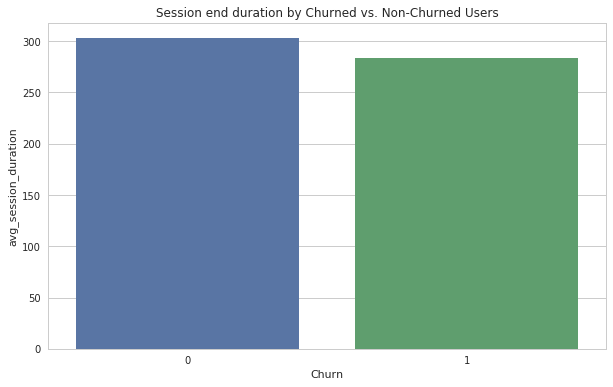

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the aesthetics for the plots
sns.set(style="whitegrid")

# Plot average number of songs played
plt.figure(figsize=(10, 6))
sns.barplot(x="Churn", y="avg_session_duration", data=session_end_pdf)
plt.title("Session end duration by Churned vs. Non-Churned Users")
plt.show()

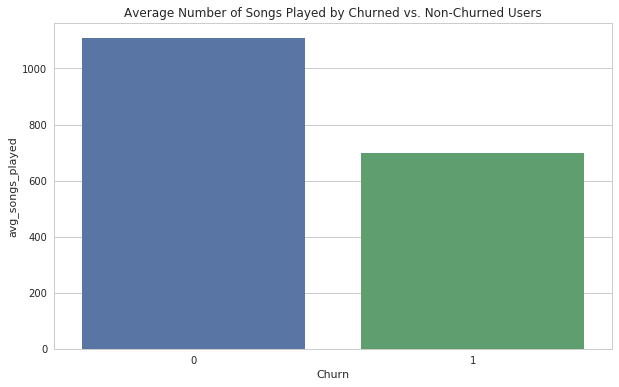

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the aesthetics for the plots
sns.set(style="whitegrid")

# Plot average number of songs played
plt.figure(figsize=(10, 6))
sns.barplot(x="Churn", y="avg_songs_played", data=songs_played_pdf)
plt.title("Average Number of Songs Played by Churned vs. Non-Churned Users")
plt.show()

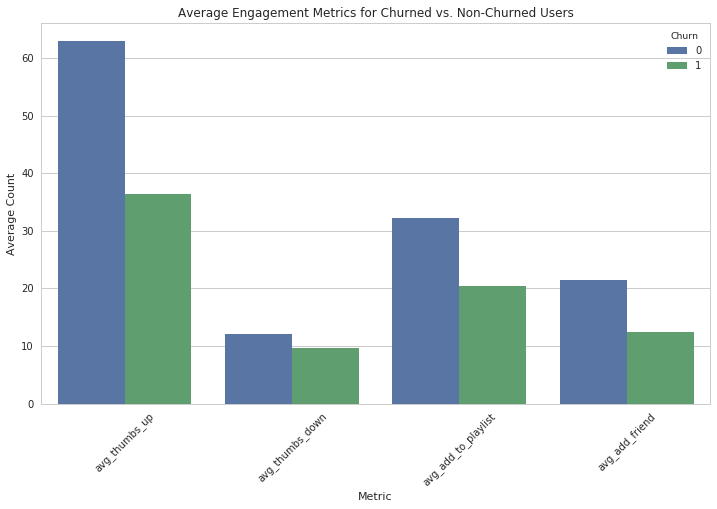

In [29]:
# Convert aggregated engagement data to Pandas DataFrame
engagement_data_pdf = engagement_data_agg.toPandas()

# Melt the DataFrame for easier plotting
engagement_melted = engagement_data_pdf.melt(id_vars=["Churn"], 
                                             value_vars=["avg_thumbs_up", "avg_thumbs_down", "avg_add_to_playlist", "avg_add_friend"], 
                                             var_name="Metric", value_name="Average Count")

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x="Metric", y="Average Count", hue="Churn", data=engagement_melted)
plt.title("Average Engagement Metrics for Churned vs. Non-Churned Users")
plt.xticks(rotation=45)
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [30]:
def generate_feature_matrix(df):
    '''
    Generate feature metrics from df   

    '''
    # Convert the ts and registration columns to Unix timestamp (epoch time in seconds)
    df = df.withColumn("ts_unix", unix_timestamp("ts"))
    df = df.withColumn("registration_unix", unix_timestamp("registration"))
 
    
    # 1. Total Songs Played
    total_songs = df.filter(col("page") == "NextSong").groupBy("userId").count().withColumnRenamed("count", "total_songs")

    # 2. Total Session Time
    session_time = df.groupBy("userId").agg(((max("ts_unix") - min("ts_unix")) / 60).alias("total_session_time"))

    # 3. Average Songs per Session
    avg_songs = df.filter(col("page") == "NextSong").groupBy("userId", "sessionId").count().groupby("userId").agg(avg("count").alias("avg_songs_per_session"))

    # 4. Number of Thumbs Up/Down:
    thumbs_up = df.filter(df.page == "Thumbs Up").groupBy("userId").count().withColumnRenamed("count", "num_thumbs_up")
    thumbs_down = df.filter(df.page == "Thumbs Down").groupBy("userId").count().withColumnRenamed("count", "num_thumbs_down")

    # 5. Total Time Since Registration:
    total_time = df.groupBy("userId").agg(((max("ts_unix") - max("registration_unix")) / (60 * 60 * 24)).alias("total_time_registered"))
    
    # 6. Number of Friends Added:
    add_friend = df.filter(df.page == "Add Friend").groupBy("userId").count().withColumnRenamed("count", "num_friends_added")

    # 7. Total Errors Encountered:
    errors = df.filter(df.page == "Error").groupBy("userId").count().withColumnRenamed("count", "num_errors")

    # 8. Number of Advertisements Played:
    ads = df.filter(df.page == "Roll Advert").groupBy("userId").count().withColumnRenamed("count", "num_ads_played")

    # 9. Paid vs Free:
    level_binary = df.select("userId", when(df.level == "paid", 1).otherwise(0).alias("paid_level"))
    level_binary = level_binary.dropDuplicates(["userId"])

    # 10. Number of Unique Artists:
    unique_artists = df.select("userId", "artist").dropDuplicates().groupBy("userId").count().withColumnRenamed("count", "num_unique_artists")

    # 11. Number of Sessions:
    num_sessions = df.select("userId", "sessionId").dropDuplicates().groupBy("userId").count().withColumnRenamed("count", "num_sessions")

    # 12. Average Time per Session:
    avg_time_per_session = df.groupBy("userId", "sessionId").agg(((max("ts_unix") - min("ts_unix")) / 60).alias("session_duration")).groupBy("userId").agg(avg("session_duration").alias("avg_session_duration"))
    
    # 13. Number of Songs Added to Playlist:
    songs_to_playlist = df.filter(df.page == "Add to Playlist").groupBy("userId").count().withColumnRenamed("count", "songs_added_to_playlist")

    # 14. Number of Upgrades or Downgrades:
    upgrades = df.filter(df.page == "Submit Upgrade").groupBy("userId").count().withColumnRenamed("count", "num_upgrades")
    downgrades = df.filter(df.page == "Submit Downgrade").groupBy("userId").count().withColumnRenamed("count", "num_downgrades")

    # Combine all feature
    feature_matrix = (
        total_songs
        .join(session_time, "userId", "outer")
        .join(avg_songs, "userId", "outer")
        .join(thumbs_up, "userId", "outer")
        .join(thumbs_down, "userId", "outer")
        .join(total_time, "userId", "outer")
        .join(add_friend, "userId", "outer")
        .join(errors, "userId", "outer")
        .join(ads, "userId", "outer") 
        .join(level_binary, "userId", "outer") 
        .join(unique_artists, "userId", "outer") 
        .join(num_sessions, "userId", "outer") 
        .join(avg_time_per_session, "userId", "outer")
        .join(songs_to_playlist, "userId", "outer")
        .join(upgrades, "userId", "outer") 
        .join(downgrades, "userId", "outer") 
        .join(user_churn, on="userId", how="left")
    )

    # Fill null values (for users who might not have any count for some events)
    feature_matrix = feature_matrix.na.fill(0)
    
    return feature_matrix


In [31]:
%%time
feature_matrix = generate_feature_matrix(df)
feature_matrix.show(10, truncate = False)

+------+-----------+------------------+---------------------+-------------+---------------+---------------------+-----------------+----------+--------------+----------+------------------+------------+--------------------+-----------------------+------------+--------------+-----+
|userId|total_songs|total_session_time|avg_songs_per_session|num_thumbs_up|num_thumbs_down|total_time_registered|num_friends_added|num_errors|num_ads_played|paid_level|num_unique_artists|num_sessions|avg_session_duration|songs_added_to_playlist|num_upgrades|num_downgrades|Churn|
+------+-----------+------------------+---------------------+-------------+---------------+---------------------+-----------------+----------+--------------+----------+------------------+------------+--------------------+-----------------------+------------+--------------+-----+
|100010|275        |63673.63333333333 |39.285714285714285   |17           |5              |55.64365740740741    |4                |0         |52            |0  

In [32]:
feature_matrix.printSchema()

root
 |-- userId: string (nullable = true)
 |-- total_songs: long (nullable = true)
 |-- total_session_time: double (nullable = false)
 |-- avg_songs_per_session: double (nullable = false)
 |-- num_thumbs_up: long (nullable = true)
 |-- num_thumbs_down: long (nullable = true)
 |-- total_time_registered: double (nullable = false)
 |-- num_friends_added: long (nullable = true)
 |-- num_errors: long (nullable = true)
 |-- num_ads_played: long (nullable = true)
 |-- paid_level: integer (nullable = true)
 |-- num_unique_artists: long (nullable = true)
 |-- num_sessions: long (nullable = true)
 |-- avg_session_duration: double (nullable = false)
 |-- songs_added_to_playlist: long (nullable = true)
 |-- num_upgrades: long (nullable = true)
 |-- num_downgrades: long (nullable = true)
 |-- Churn: integer (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [33]:
# List of features
feature_cols = ['total_songs', 'total_session_time', 'avg_songs_per_session', 'num_thumbs_up', 
                'num_thumbs_down', 'total_time_registered', 'num_friends_added', 'num_errors', 
                'num_ads_played', 'paid_level']

# add more cols
feature_cols.extend(["num_unique_artists", 
                     "num_sessions", 
                     "avg_session_duration", 
                     "songs_added_to_playlist", 
                     "num_upgrades", "num_downgrades"])

In [34]:
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.classification import RandomForestClassifier

# def train_random_forest(data, features, target_col, num_trees=100, max_depth=5):
#     """
#     Train a Random Forest Classifier using PySpark's MLlib.
    
#     Parameters:
#     - data: DataFrame containing the training data.
#     - features: List of column names in the data DataFrame to be used as features.
#     - target_col: Column name in the data DataFrame to be used as target.
#     - num_trees: Number of trees in the random forest.
#     - max_depth: Maximum depth of each tree in the random forest.
    
#     Returns:
#     - Pipeline model trained on the input data.
#     """
    
#     # Assemble features
#     assembler = VectorAssembler(inputCols=features, outputCol="features_vec")
    
#     # Initialize Random Forest Classifier
#     rf = RandomForestClassifier(labelCol=target_col, featuresCol="features_vec", numTrees=num_trees, maxDepth=max_depth)
    
#     # Set up the pipeline
#     pipeline = Pipeline(stages=[assembler, rf])
    
#     # Train the model
#     model = pipeline.fit(data)
    
#     return model

In [42]:
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

def split_dataset(data, train_fraction=0.7, test_fraction=0.15, seed=42):
    """
    Split the data into train, test, and validation sets.
    """
    train, rest = data.randomSplit([train_fraction, 1 - train_fraction], seed=seed)
    test, validation = rest.randomSplit([test_fraction / (1 - train_fraction), 
                                         1 - test_fraction / (1 - train_fraction)], 
                                        seed=seed)
    return train, test, validation



def modeling(data, features, target_col):
    """
    Model the data using RandomForest.
    """
    assembler = VectorAssembler(inputCols=features, outputCol="features_vec")
    
    rf = RandomForestClassifier(labelCol=target_col, featuresCol="features_vec", numTrees=10)
    
    pipeline = Pipeline(stages=[assembler, rf])
    model = pipeline.fit(data)
    
    return model

def evaluation(model, test_data):
    """
    Evaluate the model's performance.
    """
    predictions = model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol="Churn", metricName="f1")
    f1_score = evaluator.evaluate(predictions)
    
    return f1_score

from pyspark.ml.tuning import TrainValidationSplit

def optimized_hyperparameter_tuning(train_data, features, target_col):
    """
    Perform optimized hyperparameter tuning.
    """
    assembler = VectorAssembler(inputCols=features, outputCol="features_vec")
    rf = RandomForestClassifier(labelCol=target_col, featuresCol="features_vec", featureSubsetStrategy="sqrt")
    
    pipeline = Pipeline(stages=[assembler, rf])
    
    paramGrid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [10, 20]) \
        .addGrid(rf.maxDepth, [5, 10]) \
        .build()
    
    # Using TrainValidationSplit for faster tuning
    split = TrainValidationSplit(estimator=pipeline,
                                 estimatorParamMaps=paramGrid,
                                 evaluator=MulticlassClassificationEvaluator(labelCol=target_col, metricName="f1"),
                                 trainRatio=0.8)
    
    bestModel = split.fit(train_data)
    return bestModel



In [36]:
# split the data
train_data, test_data, validation_data = split_dataset(feature_matrix)

In [37]:
# Modelling
rf_model = modeling(train_data, features=feature_cols, target_col="Churn")

In [38]:
# Evaluation 
f1_test = evaluation(rf_model, test_data)
print(f"F1 Score on Test Data: {f1_test}")

F1 Score on Test Data: 0.9131652661064426


In [43]:
# Interpret the Model:
importances = rf_model.stages[-1].featureImportances
importance_list = [(feature, importance) for feature, importance in zip(feature_cols, importances)]
sorted_importance_list = sorted(importance_list, key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feature, importance in sorted_importance_list:
    print(f"{feature}: {importance}")

Feature Importances:
total_session_time: 0.27751268109056726
total_time_registered: 0.14659233398892035
songs_added_to_playlist: 0.08827309757669927
num_friends_added: 0.06586795618673666
avg_session_duration: 0.0653964215421873
num_thumbs_down: 0.05566514362714931
total_songs: 0.04961047220027176
num_thumbs_up: 0.04937978115684974
avg_songs_per_session: 0.04680448172725686
num_unique_artists: 0.04170472477104371
num_sessions: 0.04137576262158161
num_ads_played: 0.03341217249618633
num_downgrades: 0.01924360498483394
paid_level: 0.010490742708864265
num_upgrades: 0.005777770882040898
num_errors: 0.002892852438810847


In [ ]:
# Hyperparameter tuning
best_model = hyperparameter_tuning(train_data, features=feature_cols, target_col="Churn")

In [ ]:
# Re-Evaluation 
f1_test_tuned = evaluation(best_model, test_data)
print(f"F1 Score on Test Data with Tuned Model: {f1_test_tuned}")

In [ ]:
# FInal evaluation on validation data
final_f1_score = evaluation(best_model, validation_data)
print(f"Final Model F1 Score on Validation Data: {final_f1_score}")

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.